# 2 Exploratory Data Analysis <a id="eda"></a>

<a id="contents"></a>
## 2.1 Table of Contents

- [2 Exploratory Data Analysis](#eda)
  - [2.1 Contents](#contents)
  - [2.2 Introduction](#introduction)
      - [2.2.1 Objective](#objective)
  - [2.3 Imports](#imports)
  - [2.4 Load the Data](#dataload)
  - [2.5 Explore the Data](#explore_data)
      - [2.5.1 Missing Values](#missing_values)
      - [2.5.2 Feature Engineering](#feature_engineering)
      - [2.5.3 Outliers](#outliers)
          - [2.5.3.1 Funding & Engineered Features Outliers](#funding_outliers)
      - [2.5.4 Distributions](#distributions)
      - [2.5.5 Summary Statistics and Percentiles](#summary_stats)
  - [2.6 Visualizations](#visualizations)
      - [2.6.1 Feature Correlation Heatmap](#heatmap)
      - [2.6.2 Scatterplots of Features Against Target Variable](#scatterplots)
      - [2.6.3 Highest Inequality Districts](#inequality)
          - [2.6.3.1 Districts with High Child Poverty AND Low Total Funding](#inequality)
          - [2.6.3.2 Districts with Highest Inequality (Inequality Scores)](#inequality_score)
  - [2.7 Summary](#summary)

## 2.2 Introduction <a id="introduction"></a>

**Problem**: Despite the state's efforts to allocate funding based on Average Daily Attendance (ADA), disparities in funding raise concerns about the adequacy of resources available to each student. The core issue is whether the differences in funding, when adjusted for actual attendance versus enrollment, correlate with academic outcomes and whether this could be a contributing factor to the educational inequities lurking beneath the surface of Texas' complex system. 

Our aim is to examine the relationship between various educational variables -- school district funding in particular -- and student academic performance in Texas. By leveraging detailed financial, attendance, and academic data from the Texas Education Agency (TEA) and other sources, the project seeks to identify patterns and correlations that could inform policy decisions and interventions aimed at reducing educational disparities.

### 2.2.1 Objective <a id="objective"></a>

We'll leverage visualizations to identify potential outliers and feature correlations, as well as generate statistical summaries, the nature of distributions for each variable, and how we might handle any data cleaning or transformation that's necessary. We're looking at data from 2018-2022 (plus median income for 2023).  

## 2.3 Imports <a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.ticker as tick

from IPython import display
from ipywidgets import interact, widgets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

## 2.4 Load the Data <a id="dataload"></a>

In [2]:
# Load the dataset
data_path = '/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/student_success_all_data_merged.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,calc_for_state_acct,district_id,district_name,county,county_name,region,region_name,dist_allr_grad,dist_allr_cont,dist_allr_txchse,...,avg_base_pay,district_name_right.4,ADA,district_name_right.5,estimated_total_population,estimated_population_5_17,estimated_children_in_poverty_5_17,district_name_right.6,inequality_score,income_by_district
0,Yes,22902,Marathon ISD,22.0,Brewster County,18.0,Midland,-1.0,-1.0,-1,...,49685.0,MARATHON ISD,49.103,Marathon ISD,483.0,60.0,11.0,NaN,NaN,NaN
1,Yes,46802,Trinity Charter School,46.0,Comal County,20.0,San Antonio,-1.0,-1.0,-1,...,53900.0,TRINITY CHARTER SCHOOL,319.580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yes,65902,Hedley ISD,65.0,Donley County,16.0,Amarillo,-1.0,-1.0,-1,...,50422.0,HEDLEY ISD,117.714,Hedley ISD,465.0,65.0,17.0,NaN,NaN,NaN
3,Yes,115903,Dell City ISD,115.0,Hudspeth County,19.0,El Paso,-1.0,-1.0,-1,...,62775.0,DELL CITY ISD,46.292,Dell City ISD,472.0,49.0,20.0,NaN,NaN,NaN
4,Yes,122902,Valentine ISD,122.0,Jeff Davis County,18.0,Midland,-1.0,-1.0,-1,...,62541.0,VALENTINE ISD,34.317,Valentine ISD,260.0,6.0,5.0,NaN,NaN,NaN


**Observations**: 

* The dataset includes identifiers (district_id, district_name), categorical variables (county_name, region_name), and numerical variables (dist_allr_grad, avg_base_pay, above_crit_rate, population and poverty estimates).
* There are placeholder values of -1 for some numerical columns, which might indicate missing or non-applicable data for those records.
* Some variables have missing values (NaN), as indicated in the initial rows.
* There are also some columns with repeated district_name fields with slight variations in naming from different sources. 

## 2.5 Explore the Data <a id="explore_data"></a>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8137 entries, 0 to 8136
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   calc_for_state_acct                 5374 non-null   object 
 1   district_id                         8137 non-null   int64  
 2   district_name                       5374 non-null   object 
 3   county                              5374 non-null   float64
 4   county_name                         5374 non-null   object 
 5   region                              5374 non-null   float64
 6   region_name                         5374 non-null   object 
 7   dist_allr_grad                      5374 non-null   float64
 8   dist_allr_cont                      5374 non-null   float64
 9   dist_allr_txchse                    3237 non-null   object 
 10  dist_allr_drop                      5374 non-null   float64
 11  Year                                8137 no

### 2.5.1 Missing Values <a id="missing_values"></a>

**District Name Discrepancies**

In [4]:
# Iterate through each district name column, using nunique() to count distinct values
district_name_columns = 'district_name', 'district_name_right', 'district_name_right.1', 'district_name_right.2', 'district_name_right.4', 'district_name_right.5', 'district_name_right.6'
    
distinct_counts = {col: data[col].nunique() for col in district_name_columns}

print(distinct_counts)

{'district_name': 1138, 'district_name_right': 1172, 'district_name_right.1': 1261, 'district_name_right.2': 1013, 'district_name_right.4': 1400, 'district_name_right.5': 1007, 'district_name_right.6': 1013}


To systematically fill in the missing district_name values for rows that have the same district_id, we'll use the fillna() method in pandas along with groupby() to propagate non-null values within groups defined by district_id. The idea is to group by district_id and then apply a forward-fill (ffill()) and backward-fill (bfill()) to ensure that all NaN values are filled with the corresponding district names where available.

In [5]:
# Ensure that district_id is treated as a numeric column for correct sorting
data['district_id'] = pd.to_numeric(data['district_id'], errors='coerce')

# Sort the DataFrame by district_id to ensure that like ids are grouped together
data = data.sort_values(by='district_id')

# Replace empty strings with NaN to ensure ffill and bfill work correctly
data['district_name'].replace('', pd.NA, inplace=True)

# Then group by 'district_id' and fill NaN values forward and backward
# The lambda function applies both ffill and bfill within each group
data['district_name'] = data.groupby('district_id')['district_name'].transform(lambda x: x.ffill().bfill())

In [6]:
data.to_excel("/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/'Capstone 2 Test Merged DataFrame'.xlsx", index=False)

In [7]:
# Count distinct district_id values where district_name is still blank
distinct_count_district_id_where_name_is_null = data[data['district_name'].isnull()]['district_id'].nunique()
print(distinct_count_district_id_where_name_is_null)

# Count all distinct district_id values
distinct_counts_all_columns = data['district_id'].nunique()
print(distinct_counts_all_columns)

336
1416


Out of 1,416 unique district_id values, there are 336 w/ null values for district_name. Looking through the other district name columns in the Excel file, it's clear the vast majority of these are schools and not actual districts, and none of them have our graduation rate target variable anyway, so let's drop them. 

In [8]:
data = data.dropna(subset=['district_name'])
data.shape

(6409, 50)

Now we have 1,416 - 336 = **1,080 distinct districts in our dataset**. We should have at least **5,400 unique observations for five years worth of data 2018-2022** (1,080 X 5 = 5,400). This should be more than enough for the future modeling stage. 

In [9]:
data.to_excel("/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/'Capstone 2 Merged DataFrame -- Dropped Null district_name'.xlsx", index=False)

**Other Missing Values**

In [10]:
# Exclude 2023 data for missing value check (only median income has 2023 data)
data_2 = data[data['Year'] != 2023]

In [11]:
# Checking for missing values across the dataset
missing_values = data_2.isnull().sum()
missing_values_percentage = (missing_values / len(data_2)) * 100
dataframe_length = len(data_2)

# Combining the counts and percentages of missing values into a single dataframe for clearer presentation
missing_data_summary = pd.DataFrame({'DataFrame Length': dataframe_length, 'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})

# Displaying missing values summary sorted by percentage in descending order
missing_data_summary.sort_values(by='Percentage (%)', ascending=False)

,DataFrame Length,Missing Values,Percentage (%)
income_by_district,5440,5440,100.000000
inequality_score,5440,5440,100.000000
district_name_right.6,5440,5440,100.000000
dist_allr_txchse,5440,2203,40.496324
above_crit_rate,5440,664,12.205882
estimated_children_in_poverty_5_17,5440,611,11.231618
estimated_population_5_17,5440,611,11.231618
estimated_total_population,5440,611,11.231618
district_name_right.5,5440,611,11.231618
total_property_value,5440,562,10.330882


Columns like income_by_district and inequality_score have 100% missing values due to only having median income data for 2023, which was intentionally excluded since all other variables only have 2018-2022. Other variables exhibit moderate levels of missing data, such as dist_allr_txchse (40% missing -- probably won't need this variable anyway), above_crit_rate (about 12% missing), and various columns related to population estimates and poverty (around 11% missing). Every other variable only has around 1% or less missing values. 
* Notably, above_tsi_both_rate only has 7% missing values compared to the corresponding above_crit_rate having 12% missing -- a difference of 275 values. **Due to Above TSI Rate having less than half the missing values compared to Above Critical Rate, we might opt to use this as our SAT-ACT Scores target variable**. 

We'll need to impute data during our pre-processing stage for the prior years, especially in certain key variables like income_by_district. We will also consider excluding variables with excessively high missing percentages from certain analyses. 

### 2.5.2 Feature Engineering <a id="feature_engineering"></a>

We'll need to engineer several critical features for our analysis and include them in our dataframe so we can visualize them during this stage: 

* **Funding Metrics**: 
    * Local Funding Amount Per Student 
    * State Funding Amount Per Student
    * Federal Funding Amount Per Student
    * Total Funding Amount Per Student: Local + State + Federal
        * Funding amounts for local/state/federal and total per attended and enrolled student. 
            * Funding is allocated based on average attendance, not enrollment, but we'll want to examine whether this difference plays a role in funding inequities. 
* **Enrolled Students per Teacher**
* **Attended Students per Teacher**
* **Property Value Per Attended Student**
* **Property Value Per Enrolled Student**
* **Absenteeism Rate**: % difference b/t enrolled and avg attended. 
* **Child Poverty Rate**: % of children in poverty. 


In [12]:
# FUNDING METRICS
# Local Funding Amount
local_funding = (
    data['gen_funds_local_tax_mo'] + data['all_funds_local_tax_mo'] +
    data['gen_funds_other_local_revenue'] + data['all_funds_other_local_revenue'] +
    data['gen_funds_local_tax_is'] + data['all_funds_local_tax_is']
)

# State Funding Amount
state_funding = (
    data['gen_funds_state_revenue'] + data['all_funds_state_revenue'] +
    data['gen_funds_state_debt'] + data['all_funds_state_debt'] +
    data['gen_funds_state_trs_contrib'] + data['all_funds_state_trs_contrib'] +
    data['gen_funds_state_comp_ed_expend'] + data['all_funds_state_comp_ed_expend']
)

# Federal Funding Amount
federal_funding = data['gen_funds_federal_revenue'] + data['all_funds_federal_revenue']

# Total Funding Amount
total_funding = local_funding + state_funding + federal_funding

# Local Funding Per Attended Student
data['local_funding_per_attended_student'] = local_funding / data['ADA']

# State Funding Per Attended Student
data['state_funding_per_attended_student'] = state_funding / data['ADA']

# Federal Funding Per Attended Student
data['federal_funding_per_attended_student'] = federal_funding / data['ADA']

# Total Funding Per Attended Student
data['total_funding_per_attended_student'] = total_funding / data['ADA']

# Local Funding Per Enrolled Student
data['local_funding_per_enrolled_student'] = local_funding / data['fall_enrollment']

# State Funding Per Enrolled Student
data['state_funding_per_enrolled_student'] = state_funding / data['fall_enrollment']

# Federal Funding Per Enrolled Student
data['federal_funding_per_enrolled_student'] = federal_funding / data['fall_enrollment']

# Total Funding Per Enrolled Student
data['total_funding_per_enrolled_student'] = total_funding / data['fall_enrollment']

In [13]:
# Enrolled Students Per Teacher: 
data['enrolled_students_per_teacher'] = data['fall_enrollment'] / data['fte_count']

# Attended Students Per Teacher: 
data['attended_students_per_teacher'] = data['ADA'] / data['fte_count']

# Property Value Per Attended Student
data['property_value_per_attended_student'] = data['total_property_value'] / data['ADA']

# Property Value Per Enrolled Student
data['property_value_per_enrolled_student'] = data['total_property_value'] / data['fall_enrollment']

# Absenteeism Rate: 
data['absenteeism_rate'] = (1 - (data['ADA'] / data['fall_enrollment'])) * 100

# Child Poverty Rate: 
data['child_poverty_rate'] = (data['estimated_children_in_poverty_5_17'] / data['estimated_population_5_17']) * 100

In [14]:
data.head()

,calc_for_state_acct,district_id,district_name,county,county_name,region,region_name,dist_allr_grad,dist_allr_cont,dist_allr_txchse,...,local_funding_per_enrolled_student,state_funding_per_enrolled_student,federal_funding_per_enrolled_student,total_funding_per_enrolled_student,enrolled_students_per_teacher,attended_students_per_teacher,property_value_per_attended_student,property_value_per_enrolled_student,absenteeism_rate,child_poverty_rate
898,Yes,1902,Cayuga ISD,1.0,Anderson County,7.0,Kilgore,97.8,0.0,0.0,...,14262.533101,17894.445993,4772.231707,36929.210801,12.291221,11.633276,563369.202281,533212.264808,5.352962,16.916488
3237,Yes,1902,Cayuga ISD,1.0,Anderson County,7.0,Kilgore,96.0,2.0,NaN,...,13224.794326,12497.171986,3442.489362,29164.455674,11.341243,10.828695,521309.154316,497749.492908,4.519326,17.439703
2161,Yes,1902,Cayuga ISD,1.0,Anderson County,7.0,Kilgore,97.4,2.6,0.0,...,12929.560144,16975.113106,2835.154399,32739.827648,11.055975,10.383922,589729.329704,553881.833034,6.078636,22.803738
4305,Yes,1902,Cayuga ISD,1.0,Anderson County,7.0,Kilgore,100.0,0.0,NaN,...,11427.526957,11639.234783,2908.351304,25975.113043,11.548504,11.010805,466645.933809,444918.899130,4.656000,16.042781
1077,Yes,1902,Cayuga ISD,1.0,Anderson County,7.0,Kilgore,100.0,0.0,0.0,...,12739.123364,18981.833645,3674.970093,35395.927103,11.248949,10.835366,572530.399938,551480.543925,3.676636,15.879828


#### Drop Values

In [15]:
# Set old df to different variable to store
df_old = data
df_old.to_excel("/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/'Capstone 2 Old Merged DataFrame'.xlsx", index=False)

# Specify the columns to keep:
columns_to_keep = [
    # Pre-Existing Columns
    'income_by_district', 'above_crit_rate', 'estimated_children_in_poverty_5_17', 'estimated_population_5_17', 
    'above_tsi_both_rate', 'property_value_per_attended_student', 'property_value_per_enrolled_student', 
    'county', 'county_name', 'region_name', 'dist_allr_grad', 
    'dist_allr_drop', 'part_rate', 'district_name', 'avg_base_pay', 'fte_count', 'fall_enrollment', 
    'ADA', 'district_id', 'Year', 
    # Engineered Columns
    'local_funding_per_attended_student', 'state_funding_per_attended_student',
    'federal_funding_per_attended_student', 'total_funding_per_attended_student',
    'local_funding_per_enrolled_student', 'state_funding_per_enrolled_student',
    'federal_funding_per_enrolled_student', 'total_funding_per_enrolled_student',
    'enrolled_students_per_teacher', 'attended_students_per_teacher',
    'absenteeism_rate', 'child_poverty_rate'
    ]

# Drop all other columns
data = df_old[columns_to_keep]

In [16]:
data = data.set_index(['district_id', 'district_name', 'Year'])

In [17]:
data.head()

income_by_district  above_crit_rate  \
district_id district_name Year                                        
1902        Cayuga ISD    2022                 NaN             10.3   
                          2019                 NaN             20.8   
                          2020                 NaN              NaN   
                          2018                 NaN             20.0   
                          2021                 NaN             19.0   

                                estimated_children_in_poverty_5_17  \
district_id district_name Year                                       
1902        Cayuga ISD    2022                                79.0   
                          2019                                94.0   
                          2020                               122.0   
                          2018                                90.0   
                          2021                                74.0   

                                estimated_population_5_17  \
district_id district_name Year                              
1902        Cayuga ISD    2022                      467.0   
                          2019                      539.0   
                          2020                      535.0   
                          2018                      561.0   
                          2021                      466.0   

                                above_tsi_both_rate  \
district_id district_name Year                        
1902        Cayuga ISD    2022                 27.6   
                          2019                 62.5   
                          2020                 30.8   
                          2018                 53.3   
                          2021                 19.0   

                                property_value_per_attended_student  \
district_id district_name Year                                        
1902        Cayuga ISD    2022                        563369.202281   
                          2019                        521309.154316   
                          2020                        589729.329704   
                          2018                        466645.933809   
                          2021                        572530.399938   

                                property_value_per_enrolled_student  county  \
district_id district_name Year                                                
1902        Cayuga ISD    2022                        533212.264808     1.0   
                          2019                        497749.492908     1.0   
                          2020                        553881.833034     1.0   
                          2018                        444918.899130     1.0   
                          2021                        551480.543925     1.0   

                                    county_name region_name  ...  \
district_id district_name Year                               ...   
1902        Cayuga ISD    2022  Anderson County     Kilgore  ...   
                          2019  Anderson County     Kilgore  ...   
                          2020  Anderson County     Kilgore  ...   
                          2018  Anderson County     Kilgore  ...   
                          2021  Anderson County     Kilgore  ...   

                                federal_funding_per_attended_student  \
district_id district_name Year                                         
1902        Cayuga ISD    2022                           5042.135276   
                          2019                           3605.430530   
                          2020                           3018.646945   
                          2018                           3050.376851   
                          2021                           3815.242660   

                                total_funding_per_attended_student  \
district_id district_name Year                                       
1902        Cayuga ISD    2022                        3

In [18]:
# Drop all rows where 'ADA' = 1 or 0
data = data[~((data['ADA'] == 1) | (data['ADA'] == 0))]

**Missing Values Check 2**: 

In [19]:
# Exclude 2023
data_subset = data.loc[(data.index.get_level_values('Year') >= 2018) & (data.index.get_level_values('Year') <= 2022)]

# Checking for missing values across the dataset
missing_values = data_subset.isnull().sum()
missing_values_percentage = (missing_values / len(data_subset)) * 100
dataframe_length = len(data_subset)

# Combining the counts and percentages of missing values into a single dataframe for clearer presentation
missing_data_summary = pd.DataFrame({'DataFrame Length': dataframe_length, 'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})

# Displaying missing values summary sorted by percentage in descending order
missing_data_summary.sort_values(by='Percentage (%)', ascending=False)

,DataFrame Length,Missing Values,Percentage (%)
income_by_district,5425,5425,100.000000
above_crit_rate,5425,655,12.073733
estimated_population_5_17,5425,604,11.133641
child_poverty_rate,5425,604,11.133641
estimated_children_in_poverty_5_17,5425,604,11.133641
property_value_per_attended_student,5425,554,10.211982
property_value_per_enrolled_student,5425,554,10.211982
above_tsi_both_rate,5425,380,7.004608
part_rate,5425,80,1.474654
county,5425,60,1.105991


We see that the Above TSI Rate has close to half the missing values of the Above Critical Rate (7% vs 12%). We'll need to consider this discrepancy in which feature we choose as our target. 

In [20]:
data.shape

(6394, 29)

In [21]:
data.to_csv("/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/'Capstone 2 DataFrame (Cleaned 5)'.csv")

### 2.5.3 Outliers <a id="outliers"></a>

We'll want to check the dataset for outliers, but first, a refresher on some of our metrics... 

**Metrics Definitions Refresher**: 

* **dist_all_grad**: District all students graduation rate. 

* **dist_all_drop**: District all students dropout rate. 

* **part_rate**: Percent of graduates taking the SAT and/or ACT. 

* **above_crit_rate**: Percent of graduating examinees scoring at or above 1180 (SAT total) or 24 (ACT composite). Both these scores are above the national averages. 

* **above_tsi_both_rate**: Percent of graduating examinees meeting the college-ready graduates TSI benchmarks for the SAT or the ACT on both reading/language arts and mathematics. 

    * We'll examine the difference between the two score rates (Above_Crit_Rate and Above_TSI_Both_Rate) to determine which is optimal for gauging student performance. 

    * We'll need to combine the participation rates w/ the test score rates to best reflect each district's educational outcomes. 
* **part_rate**: Student rate of participation in standardized testing. 
* **avg_base_pay**: Teacher avg annual salary. 
* **fte_count**: Count of full-time teachers. 
* **fall_enrollment**: Total enrolled students. 
* **ADA**: Avg daily attended. 
* **Absenteeism Rate**: % difference b/t enrolled and avg attended. 
* **Child Poverty Rate**: % of children in poverty. 

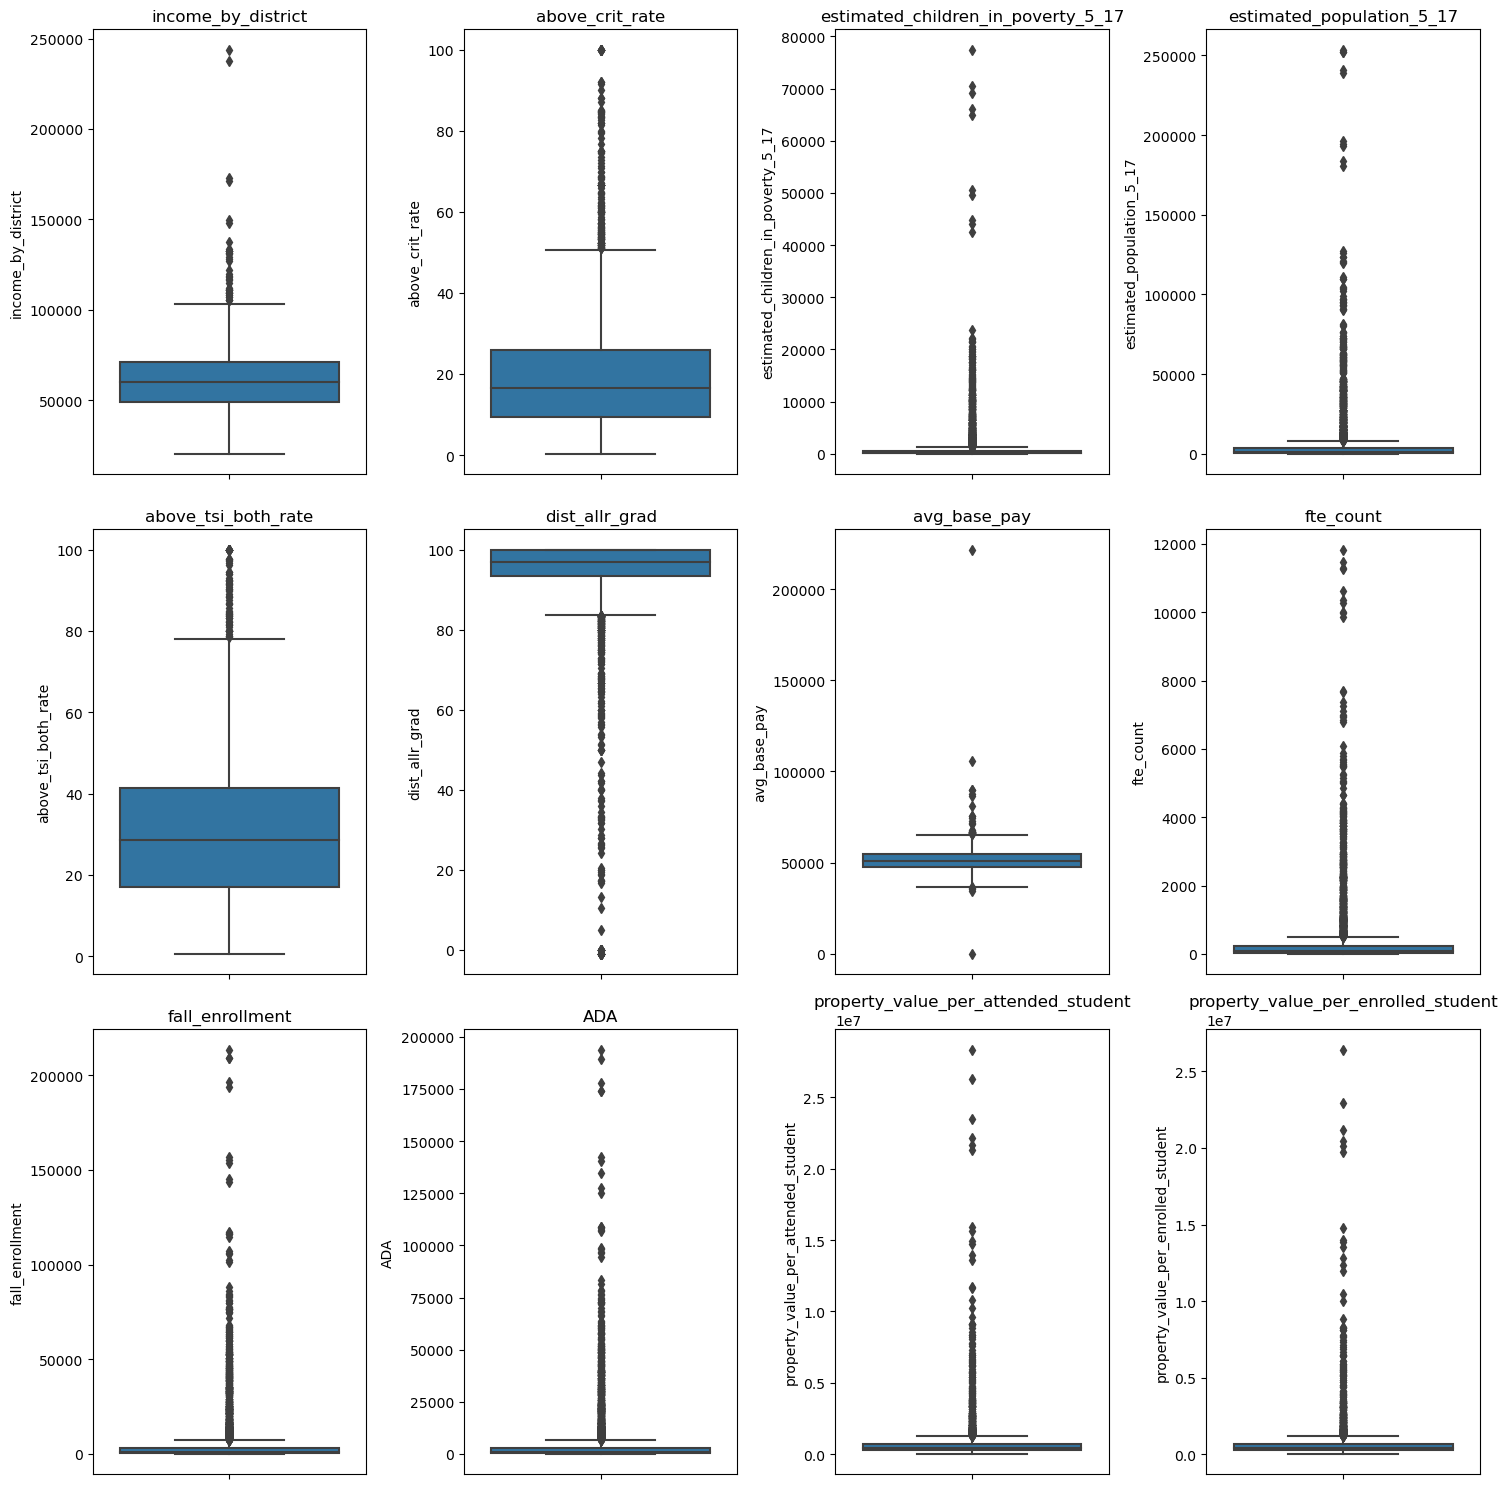

In [35]:
# Selecting a subset of numerical variables for outlier analysis
# Excluding variables with high percentage of missing values or non-applicable (-1) placeholders
numerical_vars_1 = [
    # Pre-Existing Features
    'income_by_district', 'above_crit_rate', 'estimated_children_in_poverty_5_17', 'estimated_population_5_17', 
    'above_tsi_both_rate', 
    'dist_allr_grad', 'avg_base_pay', 'fte_count', 
    'fall_enrollment', 'ADA', 
    # Engineered Features
    'property_value_per_attended_student', 'property_value_per_enrolled_student'
]

# Filter 'numerical_vars' to include only columns present in 'data'
numerical_vars_1 = [var for var in numerical_vars_1 if var in data.columns]

# Calculate the number of rows/columns for the subplot grid
n = len(numerical_vars_1)
ncols = 4  # Define the number of columns you want
nrows = n // ncols + (n % ncols > 0)  # Calculate rows needed

plt.figure(figsize=(15, 5 * nrows))  # Adjust the figure size as needed
for i, var in enumerate(numerical_vars_1):
    plt.subplot(nrows, ncols, i + 1)
    sns.boxplot(y=data[var])
    plt.title(var)

plt.tight_layout()
plt.show()

**Key Observations on Outliers:**

The boxplots for selected numerical variables reveal the **presence of outliers in the dataset for most variables**. 
* Outliers especially prevalent for variables related to population estimates (estimated_population_5_17, estimated_children_in_poverty_5_17).
* Teacher Count (fte_count), Enrollment, and Avg Daily Attended also have extreme outliers, since they all relate to the few districts that are much larger than all the rest. 
* Income by District shows a wide range in district household incomes with a median around $60,000. There are a few outliers indicating districts with exceptionally high income levels. The distribution suggests income inequality among districts.
* HS Graduation Rate (dist_allr_grad) show extreme outliers, with most values falling close to 100%. 
* The **interquartile range (IQR) of Above TSI Rate appears significantly larger than that of the Above Critical Rate, indicating a wider spread of common SAT-ACT Scores**. 
    * The distribution of the Above TSI Rate appears to be fairly consistent, with **few outliers**. The median is around 30%. This suggests that across the districts, there is a moderate level of student success as measured by SAT/ACT scores.

These outliers are visible as points that lie significantly outside the interquartile ranges (IQR) in the boxplots, indicating unusually high values compared to the majority of the data.

#### 2.5.3.1 Funding & Engineered Features Outliers <a id="funding_outliers"></a>

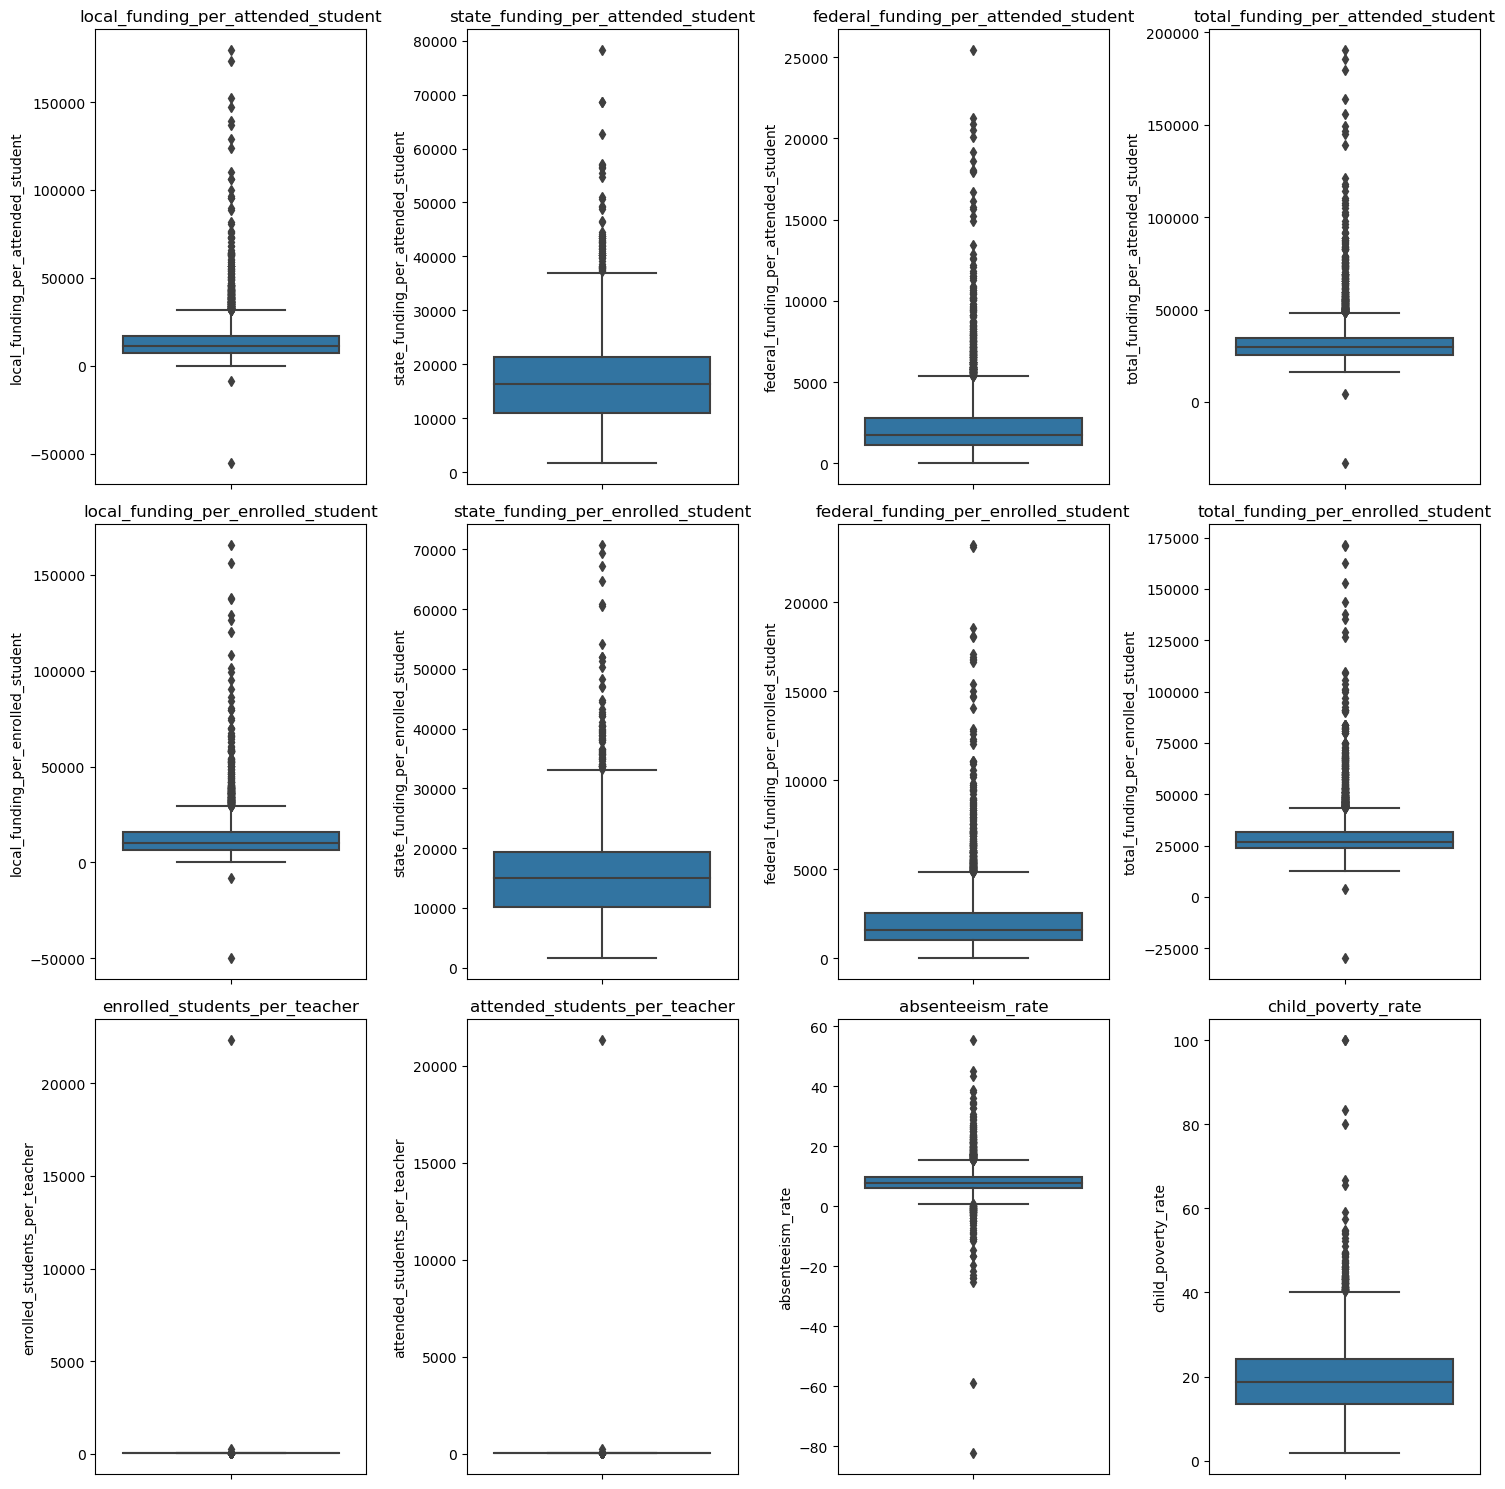

In [23]:
numerical_vars_2 = [
    # Engineered Features
    'local_funding_per_attended_student', 'state_funding_per_attended_student',
    'federal_funding_per_attended_student', 'total_funding_per_attended_student',
    'local_funding_per_enrolled_student', 'state_funding_per_enrolled_student',
    'federal_funding_per_enrolled_student', 'total_funding_per_enrolled_student',
    'enrolled_students_per_teacher', 'attended_students_per_teacher',
    'absenteeism_rate', 'child_poverty_rate'
    ]

# Filter 'numerical_vars' to include only columns present in 'data'
numerical_vars_2 = [var for var in numerical_vars_2 if var in data.columns]

# Calculate the number of rows/columns for the subplot grid
n = len(numerical_vars_2)
ncols = 4  # Define the number of columns you want
nrows = n // ncols + (n % ncols > 0)  # Calculate rows needed

plt.figure(figsize=(15, 5 * nrows))  # Adjust the figure size as needed
for i, var in enumerate(numerical_vars_2):
    plt.subplot(nrows, ncols, i + 1)
    sns.boxplot(y=data[var])
    plt.title(var)

plt.tight_layout()
plt.show()

**Key Observations on Funding Outliers:**

* The presence of outliers suggests that **certain districts receive significantly more funding per student than others. This could indicate disparities in funding allocation**. 
    * Local funding is much more skewed by outliers than state or federal funding. 
* Funding per attended vs. per enrolled boxplots are basically identical, so we'll stick with using funding per attended going forward. 

Given the presence of outliers, careful consideration is needed in subsequent analyses. For certain statistical analyses or models, it may be necessary to transform these variables (e.g., using logarithmic transformations) to reduce the impact of outliers or to consider excluding extreme outliers based on specific criteria.

### 2.5.4 Distributions <a id="distributions"></a>

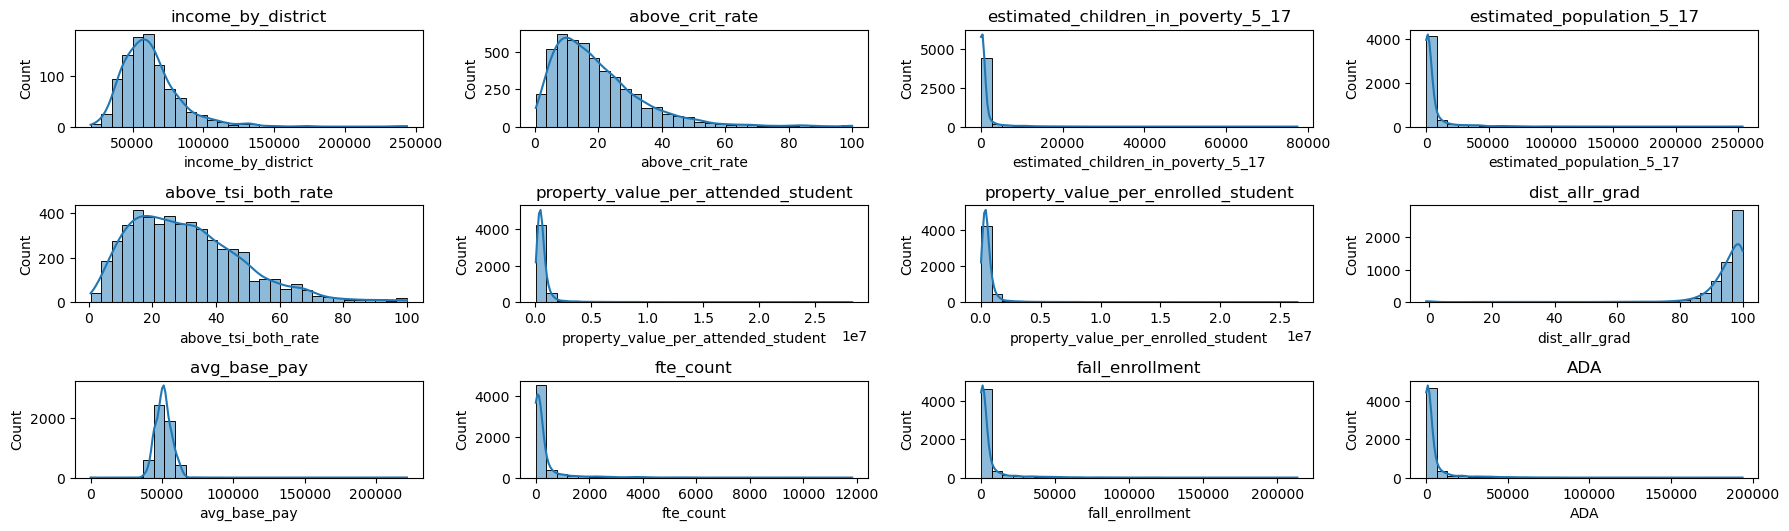

In [24]:
# Plotting distributions of pre-existing features
numerical_vars_1

# Plotting distributions of selected variables
plt.figure(figsize=(18, 12))

for i, var in enumerate(numerical_vars_1, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(var)

plt.tight_layout()
plt.show()

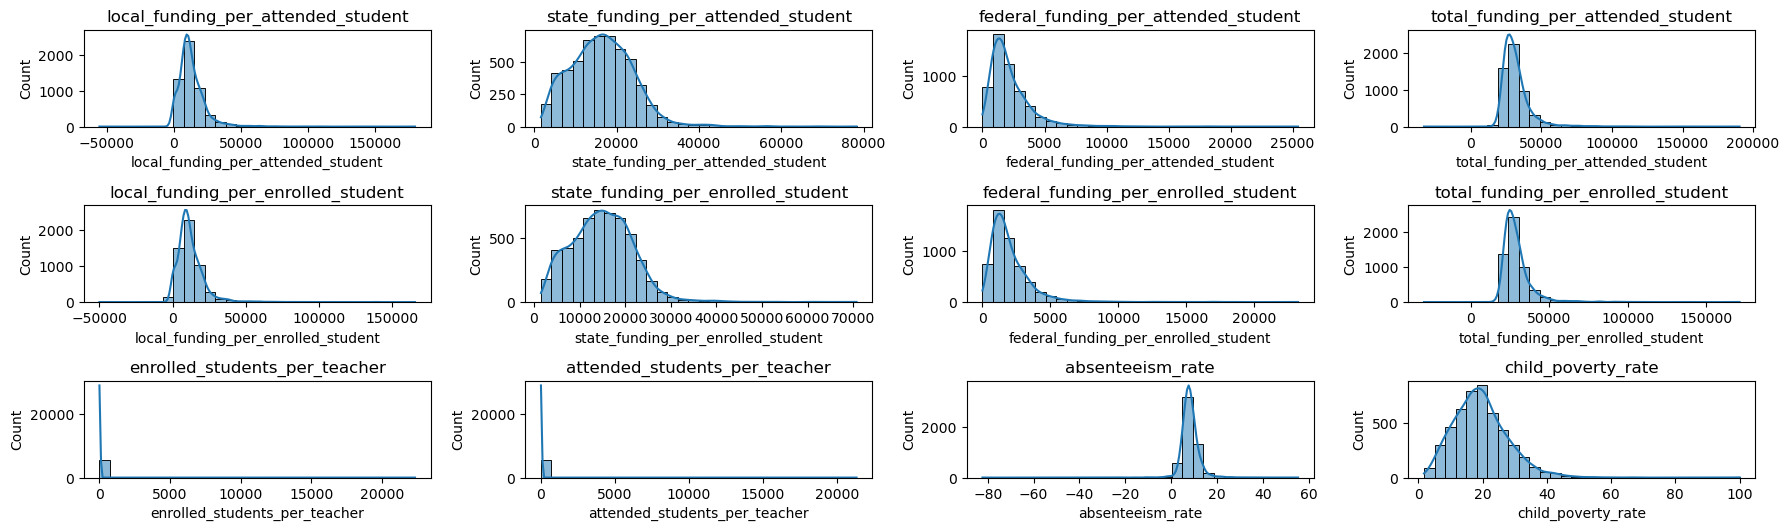

In [25]:
# Plotting distributions of engineered features (funding + others)
numerical_vars_2

# Plotting distributions of selected variables
plt.figure(figsize=(18, 12))

for i, var in enumerate(numerical_vars_2, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(var)

plt.tight_layout()
plt.show()

* Many distributions are right-skewed, indicating a concentration of districts at lower values with a long tail towards higher values. This is particularly evident in funding-related variables.
* Variables like above_crit_rate and child_poverty_rate also display skewness, suggesting variability in student success and economic conditions across districts.

To further refine our understanding, especially given the skewness, we'll now focus on distributions for data within the 90th percentile for each variable. This approach will minimize the influence of extreme outliers and provide a clearer picture of the bulk of the data.

**Distributions for data within 90th percentile**: 

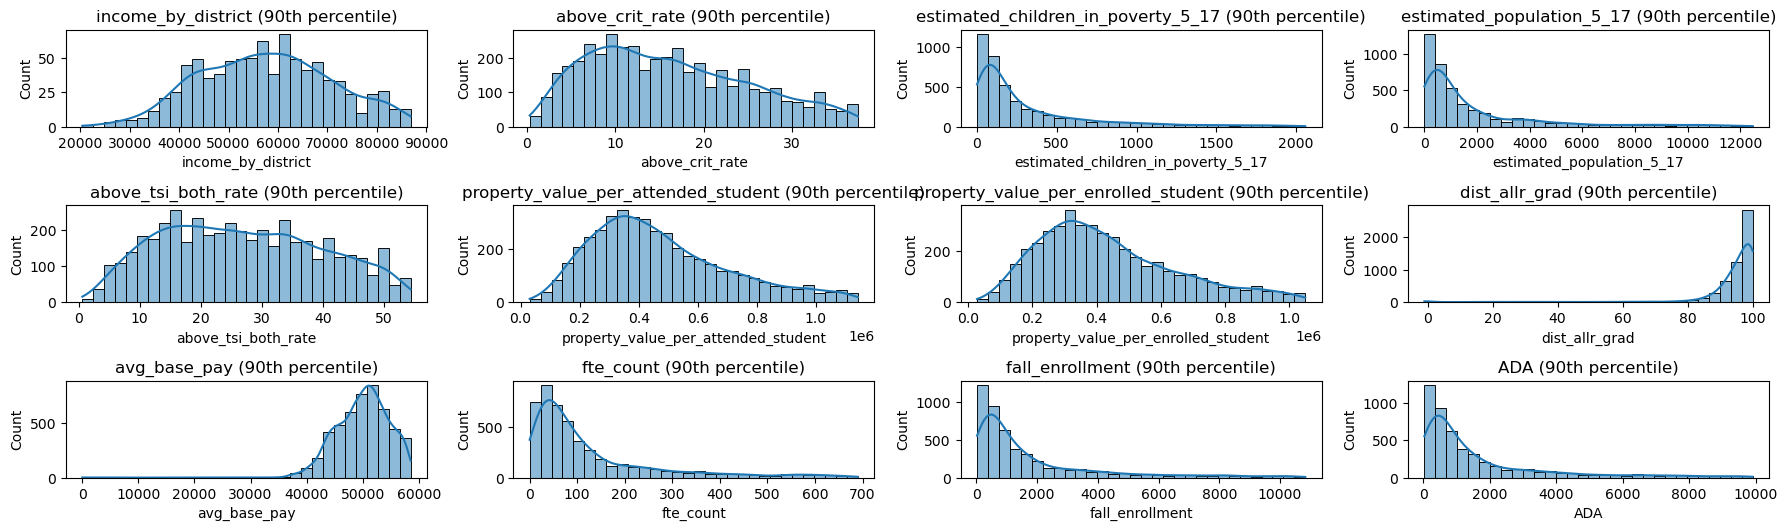

In [26]:
# Pre-Existing Feature Distributions: 

# Calculating the 90th percentile for each selected variable to limit the effect of outliers
percentile_90 = data[numerical_vars_1].quantile(0.9)

# Plotting distributions of selected variables within the 90th percentile
plt.figure(figsize=(18, 12))

for i, var in enumerate(numerical_vars_1, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[data[var] <= percentile_90[var]], x=var, kde=True, bins=30)
    plt.title(f'{var} (90th percentile)')

plt.tight_layout()
plt.show()

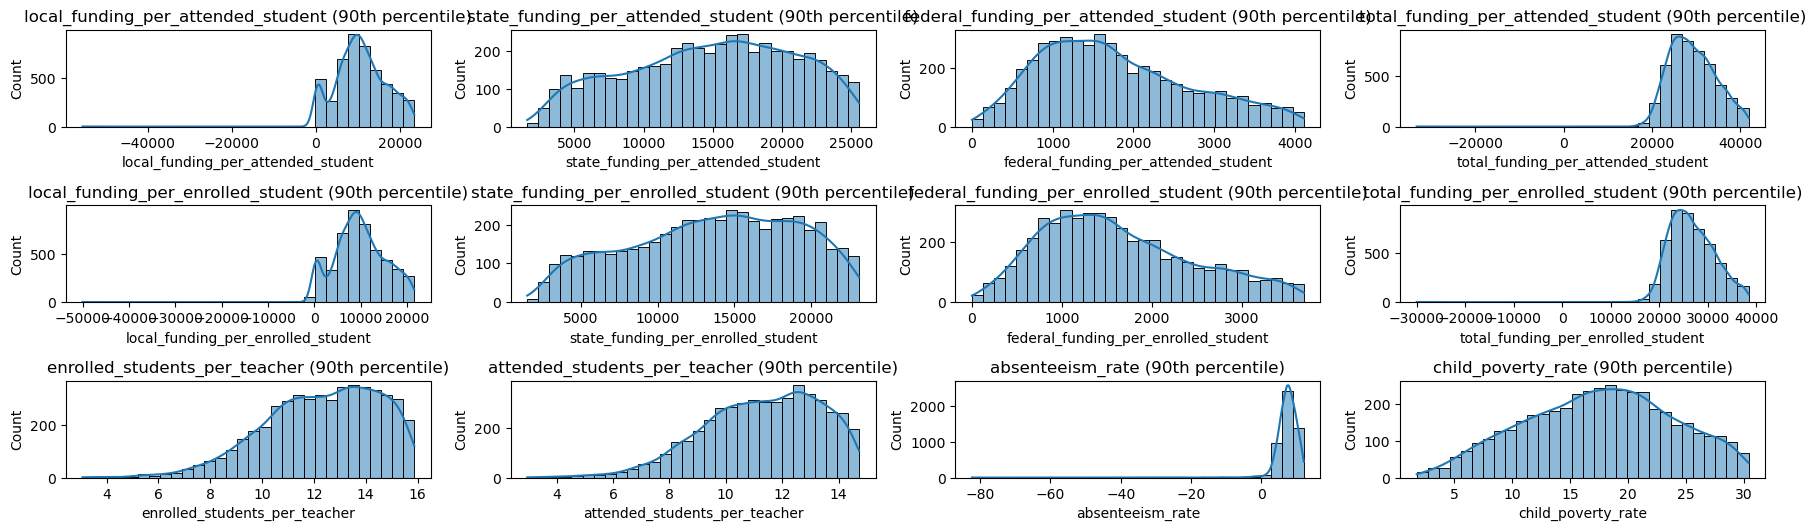

In [27]:
# Engineered Feature Distributions: 

# Calculating the 90th percentile for each selected variable to limit the effect of outliers
percentile_90 = data[numerical_vars_2].quantile(0.9)

# Plotting distributions of selected variables within the 90th percentile
plt.figure(figsize=(18, 12))

for i, var in enumerate(numerical_vars_2, 1):
    plt.subplot(7, 4, i)
    sns.histplot(data[data[var] <= percentile_90[var]], x=var, kde=True, bins=30)
    plt.title(f'{var} (90th percentile)')

plt.tight_layout()
plt.show()

By focusing on the distributions within the 90th percentile for each variable, we observe a more normalized distribution across the board. This adjustment allows for a clearer view of the data's central tendencies and variability without the distortion from extreme outliers.
* The skewness in funding-related variables is less pronounced, suggesting that the majority of districts operate within a more consistent range of funding per student.
* The above_crit_rate, child_poverty_rate, and absenteeism_rate distributions appear more symmetric, indicating a less skewed performance and condition across most districts, though some skewness remains.

### 2.5.5 Summary Statistics and Percentiles <a id="summary_stats"></a>

In [28]:
all_numerical_vars = numerical_vars_1 + numerical_vars_2

# Calculating summary statistics including the 90th percentile
summary_stats = data[all_numerical_vars].describe(percentiles=[.25, .5, .75, .9])

# Displaying summary statistics including the 90th percentile
summary_stats

,income_by_district,above_crit_rate,estimated_children_in_poverty_5_17,estimated_population_5_17,above_tsi_both_rate,property_value_per_attended_student,property_value_per_enrolled_student,dist_allr_grad,avg_base_pay,fte_count,...,federal_funding_per_attended_student,total_funding_per_attended_student,local_funding_per_enrolled_student,state_funding_per_enrolled_student,federal_funding_per_enrolled_student,total_funding_per_enrolled_student,enrolled_students_per_teacher,attended_students_per_teacher,absenteeism_rate,child_poverty_rate
count,969.000000,4770.000000,4821.000000,4821.000000,5045.00000,4.871000e+03,4.871000e+03,5365.000000,5409.000000,5409.000000,...,5425.000000,5425.000000,5425.000000,5425.000000,5425.000000,5425.000000,5409.000000,5409.000000,5425.000000,4821.000000
mean,62824.375645,19.615828,1035.928438,5659.601328,30.90224,7.106602e+05,6.523327e+05,94.313383,51176.405620,334.058989,...,2227.731069,31873.492080,12142.856431,15021.962748,2030.228009,29195.047188,17.047114,15.791612,8.200702,19.453248
std,21451.580283,14.215527,3569.916132,16137.260473,17.56117,1.280408e+06,1.168986e+06,11.597742,6138.369026,858.485923,...,1829.671621,11298.858313,10397.328358,6936.213630,1658.954178,10271.183004,303.748014,289.685293,4.205705,8.597085
min,20374.000000,0.300000,1.000000,3.000000,0.60000,3.053746e+04,2.739440e+04,-1.000000,0.000000,0.060000,...,0.000000,-33306.324579,-50043.369686,1532.842490,0.000000,-30019.618299,3.066914,2.959665,-82.341263,1.742963
25%,49076.000000,9.500000,73.000000,391.000000,17.10000,3.161019e+05,2.908338e+05,93.400000,47351.000000,38.950000,...,1122.774637,25635.525003,6590.047078,10178.397185,1038.040609,23626.237654,11.040131,10.085321,6.209789,13.513514
50%,59947.000000,16.500000,183.000000,1027.000000,28.50000,4.592174e+05,4.223479e+05,97.000000,50958.000000,81.820000,...,1754.541296,29515.500428,10171.430886,14912.044128,1613.230912,26928.308420,12.928760,11.858087,7.902017,18.761384
75%,71250.000000,25.900000,582.000000,3563.000000,41.50000,7.082141e+05,6.558395e+05,100.000000,54605.000000,223.880000,...,2823.917436,34704.886044,15657.500874,19398.449925,2561.085561,31525.025137,14.620259,13.448008,9.858458,24.261275
90%,86855.000000,37.500000,2057.000000,12472.000000,54.30000,1.142751e+06,1.050400e+06,100.000000,58523.800000,691.268000,...,4108.975944,41848.724958,21565.390270,23094.049878,3688.935167,38390.422483,15.875494,14.727449,12.075297,30.414013
max,243911.000000,100.000000,77464.000000,253709.000000,100.00000,2.832476e+07,2.641660e+07,100.000000,221633.000000,11833.560000,...,25436.910340,190417.945253,165459.281457,70708.309211,23213.492117,171401.882883,22350.000000,21314.800000,55.387245,100.000000


**Observations**: 
* Total Funding per Attended Student: The median funding is around $29k, with a significant standard deviation indicating wide variability. 
* Funding Per Enrolled Student: 
    * Maximum value of local funding per enrolled student is more than double that of state funding (165k vs 70k). This indicates **differences in property taxes derived from high property values are driving funding inequities across districts**. 
* SAT-ACT Scores: 
    * Above Critical Rate: Median = 16%, with a 90th percentile at 37%, indicating that most districts have lower success rates, but a few significantly outperform.
    * Above TSI Both Rate: Median = 28%, with a 90th percentile at 54%. There is also a slightly higher standard deviation compared to above critical rate. 
* Child Poverty Rate: Mean rate is close to 19.45%, with a broad distribution up to the 90th percentile at 30.4%, reflecting varying socioeconomic conditions.
* Absenteeism Rate: Averages at 8.35% with the 90th percentile at 12.14%, showing a moderate level of absenteeism in most districts but slightly higher levels in some.

## 2.6 Visualizations  <a id="visualizations"></a>

### 2.6.1 Feature Correlation Heatmap <a id="heatmap"></a>

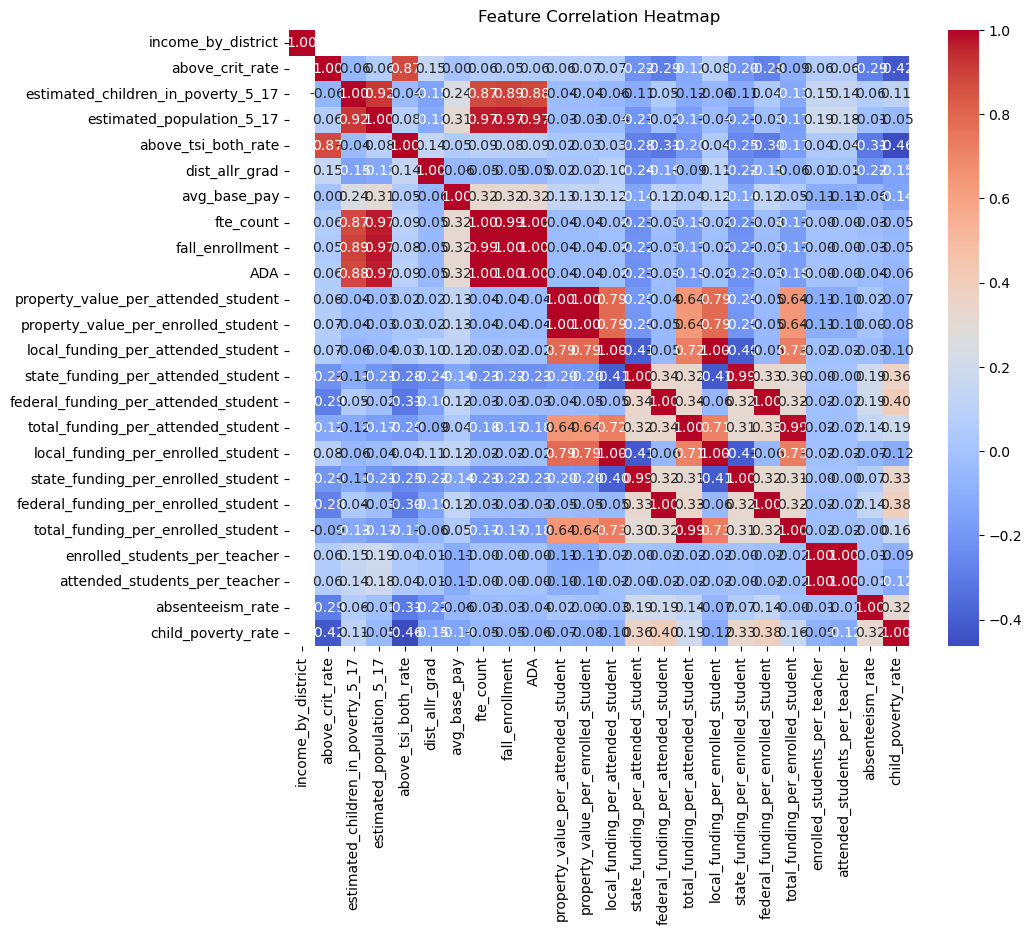

In [36]:
# Generating a correlation matrix for selected variables including the target variable
correlation_vars = [
    # Pre-Existing Features
    'income_by_district', 'above_crit_rate', 'estimated_children_in_poverty_5_17', 'estimated_population_5_17', 
    'above_tsi_both_rate', 'dist_allr_grad', 'avg_base_pay', 'fte_count', 'fall_enrollment', 'ADA', 
    # Engineered Features
    'property_value_per_attended_student', 'property_value_per_enrolled_student',
    'local_funding_per_attended_student', 'state_funding_per_attended_student',
    'federal_funding_per_attended_student', 'total_funding_per_attended_student',
    'local_funding_per_enrolled_student', 'state_funding_per_enrolled_student',
    'federal_funding_per_enrolled_student', 'total_funding_per_enrolled_student',
    'enrolled_students_per_teacher', 'attended_students_per_teacher',
    'absenteeism_rate', 'child_poverty_rate'
    ]
correlation_matrix = data[correlation_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

**Highlights from the correlation matrix**: 

* Notably, **none of our funding specific variables show positive correlations with our target variables of SAT-ACT Score (above_crit_rate) or HS Graduation Rate (dist_allr_grad). This debunks our initial hypothesis that higher funding is correlated with higher student success, indicating other factors are more important**. 
    * In fact, HS graduation rate (dist_allr_grad) doesn't have ANY variables positively correlated or meaningfully negatively correlated to it, so this likely won't be used as our target variable in our modeling stage. 
* **Funding Per Attended Student**: Total funding is strongly correlated with local funding, which indicates that property taxes constitute the bulk of the total funding. 
* **Students Per Teacher**: This has no correlation to our target variables, or any other variables at all, indicating students per teacher is not a leading factor in our success metrics. 
* **Teacher Avg Salary**: No correlation to the target variables. 

Let's zoom in on the most significant feature correlations to see how they compare to both Above TSI Rate and Above Critical Rate, as well as our HS Graduation Rate.

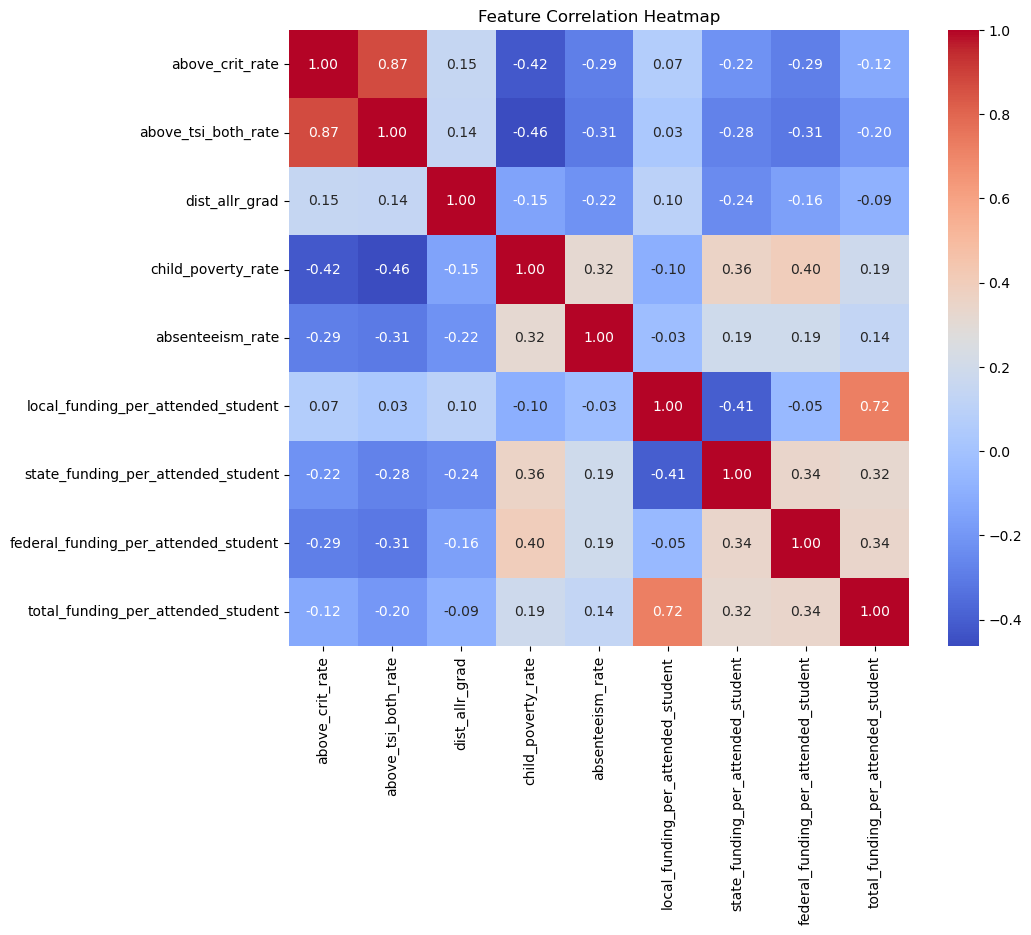

In [30]:
# Generating a correlation matrix for selected variables including the target variable
correlation_vars = ['above_crit_rate', 'above_tsi_both_rate', 'dist_allr_grad', 'child_poverty_rate', 
                    'absenteeism_rate', 'local_funding_per_attended_student','state_funding_per_attended_student', 
                    'federal_funding_per_attended_student', 'total_funding_per_attended_student', 
                    ]
correlation_matrix = data[correlation_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

* The state claims that they generally allocate more state funding to districts with lower local funding from property taxes, and this appears to be true from the data: the correlation between state funding per attended and local funding per attended is -0.41. 
* The correlations between our two potential target variables (Above TSI Rate and Above Critical Rate) appear to be largely identical, with correlations slightly higher for TSI Rate compared to Critical Rate for the same features. 
* **Correlations to Above TSI Rate**: 
    * Notably, **Child Poverty Rate has a significant negative correlation with Above TSI Rate (-0.46)**, reinforcing the concept that socioeconomic background is a key factor in student success.
        * Child Poverty Rate is also correlated with Absenteeism Rate, indicating kids in high poverty districts are more likely to miss school consistently. 
    * **Absenteeism Rate and Federal Funding Per Attended Student are also negatively correlated to test scores (-0.31)**. 
    * **State Funding Per Attended Student has a weak-moderate negative correlation (-0.28)**. 
        * This is interesting to see: the lower the state funding, generally the higher the test scores. This seems counterintuitive, but state funding might be distributed more to schools that need extra support, which could be schools with lower test scores. Therefore, the schools with higher test scores might not receive as much state funding because they're not seen as needing it. 
        * Also, both state and federal funding per enrolled is positively correlated to child poverty rate (0.33 and 0.37), indicating that the state and federal governments are more likely to increase funding to districts with higher child poverty, which is a good thing.
     

Here are the features with the highest to lowest correlations with our target feature Above TSI Rate: 

In [31]:
# ORDER OF FEATURES HIGHEST TO LOWEST CORRELATION W/ ABOVE TSI RATE

# Exclude certain non-numeric or identifier columns
columns_to_exclude = ['district_id', 'district_name', 'Year', 'region', 'region_name', 'county', 'county_name']

# Select only numeric columns and exclude specified non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
columns_for_correlation = [column for column in numeric_columns if column not in columns_to_exclude]

# Create a DataFrame with only the desired numeric columns for correlation
data_corr = data[columns_for_correlation]

# Now you can calculate the correlation matrix
correlation_matrix = data_corr.corr()

# Sorting the correlations with the target variable 'above_crit_rate'
columns_to_drop = ['above_crit_rate', 'above_tsi_both_rate']

# Drop multiple target variables
correlations_with_target = correlation_matrix['above_tsi_both_rate'].drop(columns_to_drop)

# Calculate the absolute values and sort
correlations_with_target = correlations_with_target.abs().sort_values(ascending=False)

print(correlations_with_target)

child_poverty_rate                      0.462983
federal_funding_per_attended_student    0.309960
absenteeism_rate                        0.306499
federal_funding_per_enrolled_student    0.298480
state_funding_per_attended_student      0.276407
state_funding_per_enrolled_student      0.254687
total_funding_per_attended_student      0.200028
dist_allr_drop                          0.185052
total_funding_per_enrolled_student      0.169233
dist_allr_grad                          0.137316
ADA                                     0.088021
fte_count                               0.086197
estimated_population_5_17               0.084483
fall_enrollment                         0.080297
part_rate                               0.061519
avg_base_pay                            0.054172
estimated_children_in_poverty_5_17      0.044766
attended_students_per_teacher           0.044393
enrolled_students_per_teacher           0.043855
local_funding_per_enrolled_student      0.043368
local_funding_per_at

### 2.6.2 Scatterplots of Features Against Target Variable  <a id="scatterplots"></a>

Let's illustrate how our main features negatively correlate to our target variable of SAT-ACT Scores (above_tsi_both_rate). 

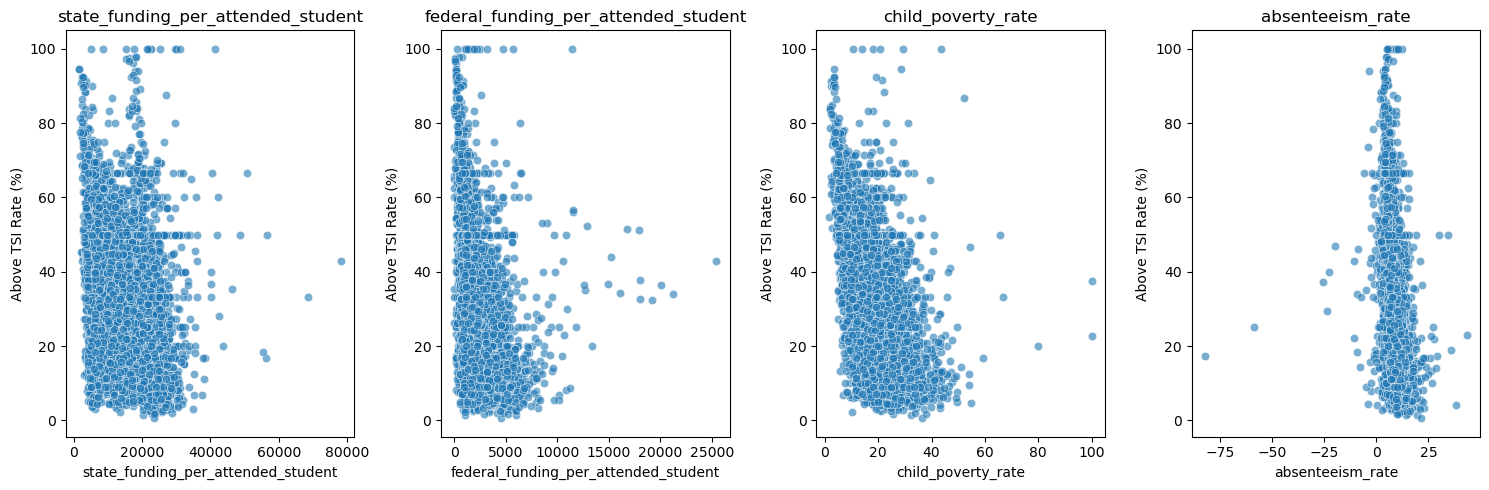

In [32]:
# Scatterplots of key features against the target variable 'above_crit_rate'
features_against_target = ['state_funding_per_attended_student', 'federal_funding_per_attended_student', 
                           'child_poverty_rate', 'absenteeism_rate']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features_against_target, 1):
    plt.subplot(1, 4, i)
    sns.scatterplot(data=data, x=feature, y='above_tsi_both_rate', alpha=0.6)
    plt.title(f'{feature}')
    plt.xlabel(feature)
    plt.ylabel('Above TSI Rate (%)')

plt.tight_layout()
plt.show()

### 2.6.3 Highest Inequality Districts <a id="inequality"></a>

#### 2.6.3.1 Districts with High Child Poverty AND Low Total Funding <a id="inequality"></a>
         

We'll visualize districts with funding inequities, particularly those with low total funding per student alongside high child poverty rates. We'll plot these relationships and highlight districts meeting these criteria (each dot represents a district in a given year from 2018-2022). 

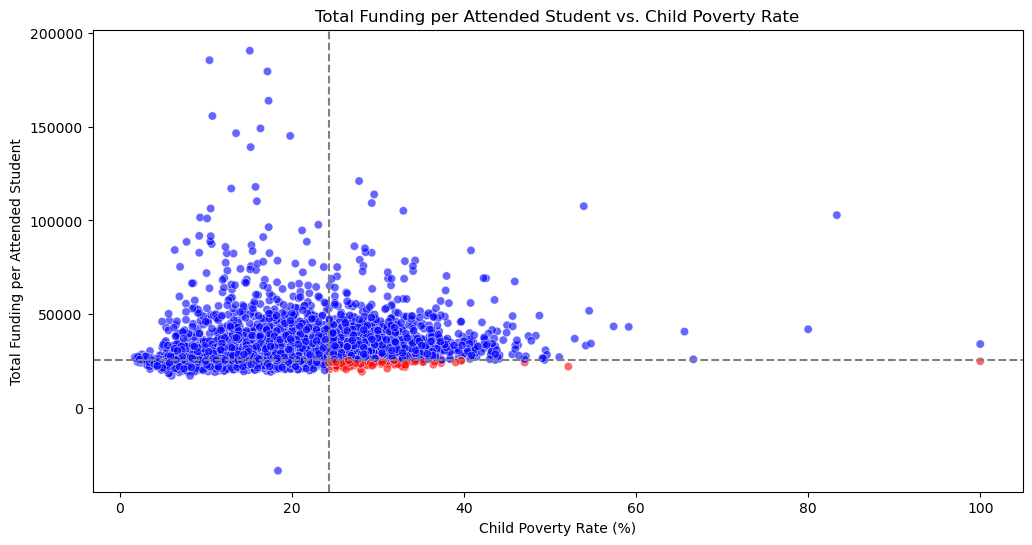

In [33]:
# Scatterplot of Total Funding per Attended Student vs. Child Poverty Rate
plt.figure(figsize=(12, 6))

# Identifying districts with low total funding (below 25th percentile) and high child poverty rate (above 75th percentile)
low_funding_threshold = data['total_funding_per_attended_student'].quantile(0.25)
high_poverty_threshold = data['child_poverty_rate'].quantile(0.75)

# Marking districts with low funding and high poverty
marker_condition = (data['total_funding_per_attended_student'] <= low_funding_threshold) & (data['child_poverty_rate'] >= high_poverty_threshold)

sns.scatterplot(data=data, x='child_poverty_rate', y='total_funding_per_attended_student', hue=marker_condition, palette={True: 'red', False: 'blue'}, legend=False, alpha=0.6)
plt.title('Total Funding per Attended Student vs. Child Poverty Rate')
plt.xlabel('Child Poverty Rate (%)')
plt.ylabel('Total Funding per Attended Student')
plt.axhline(low_funding_threshold, color='grey', linestyle='--')
plt.axvline(high_poverty_threshold, color='grey', linestyle='--')

plt.show()

* The scatterplot illustrates the relationship between total funding per attended student and child poverty rate across districts, with districts falling into the low funding and high poverty category marked in red. The grey dashed lines indicate the thresholds for low funding (below the 25th percentile of total funding) and high child poverty (above the 75th percentile).
* Districts marked in red are of particular concern, as they represent situations where low funding coincides with high poverty rates, potentially exacerbating educational inequities. These districts might require targeted interventions to address disparities in funding and support students from socioeconomically challenged backgrounds.

#### 2.6.3.2 Districts with Highest Inequality (Inequality Scores) <a id="inequality_score"></a>

It would be interesting to see if there are districts with ultimate inequality: some combination of low total funding, high child poverty, low property values, high students per teacher, AND low avg teacher pay. 

We'll create a composite inequality score based on these factors and then visualize the districts with the highest inequality scores.

First, we'll create a score for each district by standardizing the variables (so that each variable contributes equally to the score regardless of its scale). Then, we'll sum these standardized scores to get a composite score. We could then plot these scores for each district.

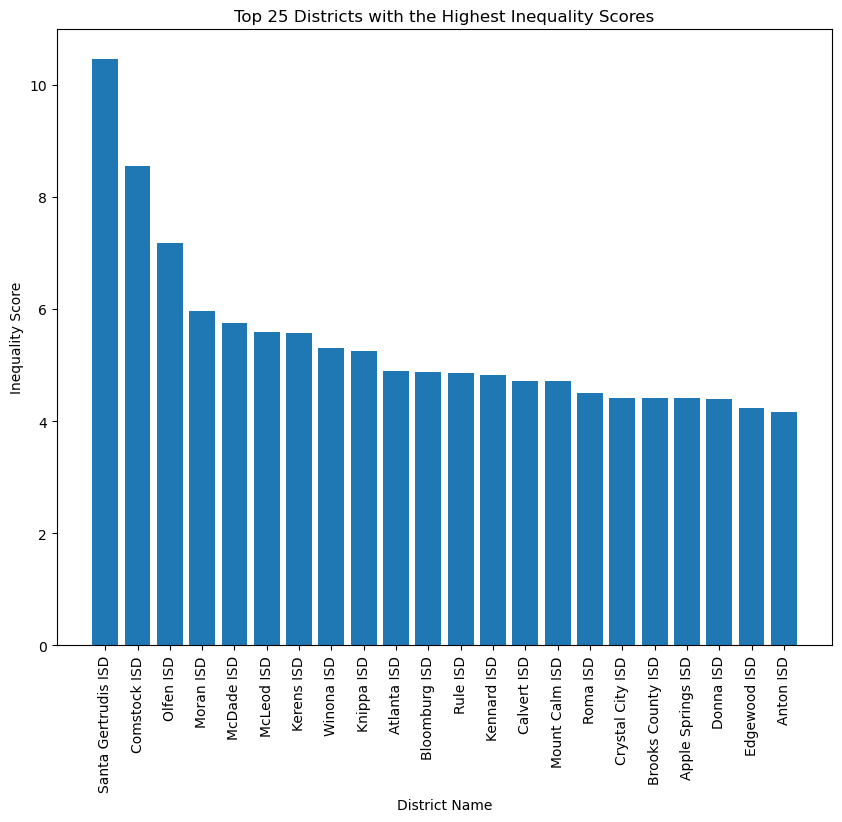

In [34]:
# Standardize the variables where lower values are worse (funding and teacher pay)
# and higher values are worse for inequality (poverty rate, students per teacher)
data_i = data.reset_index()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_i[['total_funding_per_attended_student', 'child_poverty_rate', 
                                         'property_value_per_attended_student', 'attended_students_per_teacher',
                                         'avg_base_pay']])

# Flip the sign for the standardized values of funding, property value, and teacher pay 
# so that higher standardized values always indicate higher inequality
data_scaled[:, 0] = -data_scaled[:, 0]  # total funding
data_scaled[:, 2] = -data_scaled[:, 2]  # property value per student
data_scaled[:, 4] = -data_scaled[:, 4]  # avg teacher pay

# Calculate the inequality score by summing across the standardized values
data_i['inequality_score'] = data_scaled.sum(axis=1)

# Sort districts by the inequality score
data_sorted = data_i.sort_values('inequality_score', ascending=False)

# Select the top 25 districts with the highest inequity scores
top_25_districts = data_sorted.head(25)

# Visualization: Bar chart of the 25 districts with the highest inequality scores
plt.figure(figsize=(10, 8))
plt.bar(top_25_districts['district_name'], top_25_districts['inequality_score'])
plt.title('Top 25 Districts with the Highest Inequality Scores')
plt.xlabel('District Name')
plt.ylabel('Inequality Score')
plt.xticks(rotation=90)  # Rotate the district names for better readability
plt.show()

Three Texas school districts appear to have especially high levels of inequality based on the highest inequality scores: Santa Gertrudis ISD, Comstock ISD, and Olfen ISD. 

## 2.7 Summary <a id="summary"></a>

* **MISSING VALUES**: Dropped a few unneeded columns with high missing values, and saw our target variable above_crit_rate had a few missing values. 
    * **District Name Discrepancies Rectified**: Systematically filled in the missing district_name values. 
* **OUTLIERS**: The presence of outliers suggested further investigation. Depending on the context, it might be appropriate to apply outlier treatment methods or consider these values in the modeling stage. 
    * The interquartile range of Above TSI Rate appears significantly larger than that of the Above Critical Rate, indicating a wider spread of common SAT-ACT Scores. It is also far less skewed by outliers. 
    * Our funding boxplots point towards significant disparities in funding across different districts, suggesting a complex picture of educational funding that may influence educational quality and outcomes. Further analysis could investigate the reasons behind these disparities, their impact on educational opportunities, and potential policy implications.
* **DISTRIBUTIONS**: Many distributions were initially highly skewed, but when taking distributions on the 90th percentiles of each feature, most showed a more normal distribution. 
* **SUMMARY STATS**: These statistics highlight the disparities and variability in funding, performance, and socio-economic conditions across the districts. The presence of significant outliers, especially in funding, could have implications for policy and resource allocation to address these disparities. 
    * **Differences in property taxes derived from high property values are driving funding inequities across districts (local funding per student max = 165k; state funding per student max = 70k)**. 
* **CORRELATIONS**: Overall, the correlation matrix highlights complex relationships between educational funding, socioeconomic factors, and student success metrics. These insights could be useful for policymakers and educators in understanding the multifaceted influences on educational outcomes and in designing interventions to improve student success.
    * Both state and federal funding per attended is positively correlated to child poverty rate (0.33 and 0.37), indicating that the state and federal governments are more likely to increase funding to districts with higher child poverty, which is a good thing. 
* **TARGET FEATURE SELECTION**: 
    * Due to a **wider spread** of values, **fewer outliers**, slightly **higher correlations** among similar features, and **roughly half the missing values** compared to Above Critical Rate, **we chose Above TSI Rate as our SAT-ACT scores target variable**.  
    * **Due to HS Graduation Rate having zero variables with any positive or meaningful negative correlation to it, we dropped this value as a target variable** and focused instead on SAT-ACT Scores as our sole target (Above TSI Rate).
* **HIGHLIGHTS**: 
    * There are significant disparities in funding across different districts, with local funding from property taxes as the primary driver.  
        * The state claims that they generally allocate more state funding to districts with lower local funding from property taxes, and this appears to be true from the data: the correlation between state funding per attended and local funding per attended is -0.41. 
    * Interestingly, NONE of our funding specific variables show positive correlations with our target variable of SAT-ACT Score (above_tsi_both_rate) or potential target of HS graduation rate (dist_allr_grad). **This debunks our initial hypothesis that higher funding is correlated with higher student success, indicating other factors are more important**. 
    * Our chosen target variable of **SAT-ACT Scores (Above TSI Rate) had three variables moderately negatively correlated with it: Child Poverty Rate (-0.46), Federal Funding Per Attended Student (-0.31), and State Funding Per Attended Student (-0.31)**. We had one more variable **Absenteeism Rate with a weak-moderate negative correlation (-0.28)**. 
        * These negative correlations highlight important educational realities: **higher child poverty and higher absenteeism tends to result in lower test scores among school districts**. It's interesting that both higher federal and state funding per attended tends to result in lower scores. 